# Filtering data
One of PyProBE's main strengths is to be able to filter data quickly and with natural language. This example shows the power of the filtering functions available.

Start by importing PyProBE and the dataset:

In [1]:
%%capture
%pip install matplotlib

In [2]:
import pyprobe
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
info_dictionary = {
    "Name": "Sample cell",
    "Chemistry": "NMC622",
    "Nominal Capacity [Ah]": 0.04,
    "Cycler number": 1,
    "Channel number": 1,
}
data_directory = "../../../tests/sample_data/neware"

# Create a cell object
cell = pyprobe.Cell(info=info_dictionary)
cell.add_procedure(
    procedure_name="Sample",
    folder_path=data_directory,
    filename="sample_data_neware.parquet",
)

Plot the entire dataset:

<Axes: xlabel='Time [s]'>

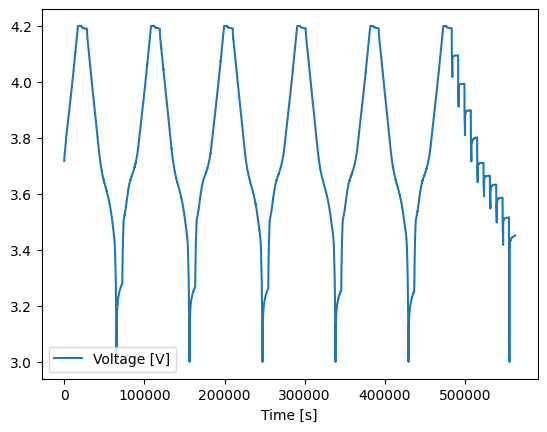

In [4]:
full_procedure = cell.procedure["Sample"]
full_procedure.plot(x="Time [s]", y="Voltage [V]")

A `README.yaml` file is stored alongside this dataset, which appears like this:

In [5]:
with open(data_directory + "/README.yaml", "r") as file:
    readme = file.read()
    print(readme)

Initial Charge: # Experiment title
  Steps: # Steps list, descriptions are PyBaMM experiment strings
    1: Rest for 4 hours # Start with index 1
    # CC-CV charge provided as two seperate PyBaMM experiment strings
    2: Charge at 4mA until 4.2 V, Hold at 4.2 V until 0.04 A 
    3: Rest for 2 hours
Break-in Cycles:
  Steps: 
    4: Discharge at 4 mA until 3 V
    5: Rest for 2 hours
    6: Charge at 4 mA until 4.2 V, Hold at 4.2 V until 0.04 A
    7: Rest for 2 hours
  Cycle: # Cycle instruction, contains start, end and count
    Start: 4 # loop starts with step 4 (inclusive)
    End: 7 # loop ends with step 7 (inclusive)
    Count: 5
Discharge Pulses:
  Steps: 
    # Neware considers cycling (in previous experiment) to be its own step,
    # so Step 8 is skipped
    9: Rest for 10 seconds
    10: Discharge at 20 mA for 0.2 hours or until 3 V
    11: Rest for 30 minutes
    12: Rest for 1.5 hours
  Cycle:
    Start: 9
    End: 12
    Count: 10



Constructing the README file in this way allows three separate experiments to be separated out from the data:

Text(0, 0.5, 'Voltage [V]')

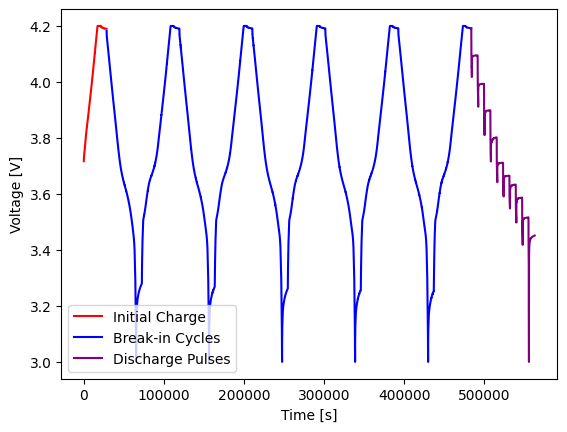

In [6]:
initial_charge = full_procedure.experiment("Initial Charge")
break_in = full_procedure.experiment("Break-in Cycles")
pulses = full_procedure.experiment("Discharge Pulses")

fig, ax = plt.subplots()
initial_charge.plot(
    x="Time [s]", y="Voltage [V]", ax=ax, color="red", label="Initial Charge"
)
break_in.plot(
    x="Time [s]", y="Voltage [V]", ax=ax, color="blue", label="Break-in Cycles"
)
pulses.plot(
    x="Time [s]", y="Voltage [V]", ax=ax, color="purple", label="Discharge Pulses"
)
ax.set_ylabel("Voltage [V]")

Selecting the Break-in Cycles experiment, we can filter further:

Text(0, 0.5, 'Voltage [V]')

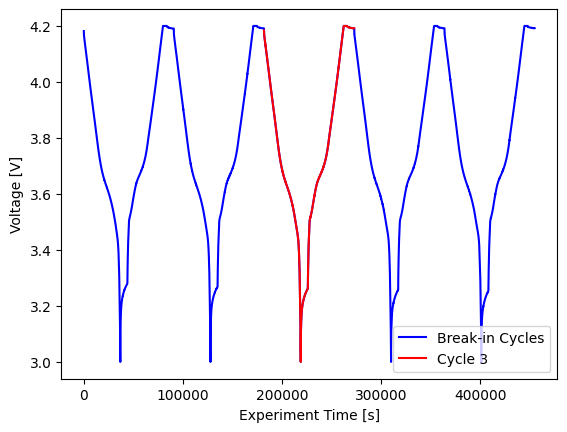

In [7]:
cycle_3 = break_in.cycle(
    2
)  # python zero-indexing means we use index 2 to retrieve the third cycle

fig, ax = plt.subplots()
break_in.plot(
    x="Experiment Time [s]",
    y="Voltage [V]",
    ax=ax,
    color="blue",
    label="Break-in Cycles",
)
cycle_3.plot(
    x="Experiment Time [s]", y="Voltage [V]", ax=ax, color="red", label="Cycle 3"
)
ax.set_ylabel("Voltage [V]")

We can break this down further into charge, discharge and rest sections:

Text(0, 0.5, 'Voltage [V]')

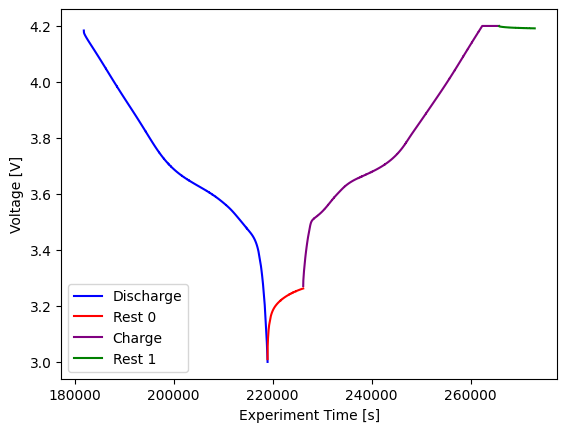

In [8]:
discharge = cycle_3.discharge()
rest_0 = cycle_3.rest(0)
charge = cycle_3.charge()
rest_1 = cycle_3.rest(1)

fig, ax = plt.subplots()
discharge.plot(
    x="Experiment Time [s]", y="Voltage [V]", ax=ax, color="blue", label="Discharge"
)
rest_0.plot(
    x="Experiment Time [s]", y="Voltage [V]", ax=ax, color="red", label="Rest 0"
)
charge.plot(
    x="Experiment Time [s]", y="Voltage [V]", ax=ax, color="purple", label="Charge"
)
rest_1.plot(
    x="Experiment Time [s]", y="Voltage [V]", ax=ax, color="green", label="Rest 1"
)
ax.set_ylabel("Voltage [V]")

Some cyclers will split constant voltage and constant current instructions into two separate steps. That is not the case for the cycler used for this dataset, but we can still extract them with PyProBE filtering:

Text(0, 0.5, 'Current [A]')

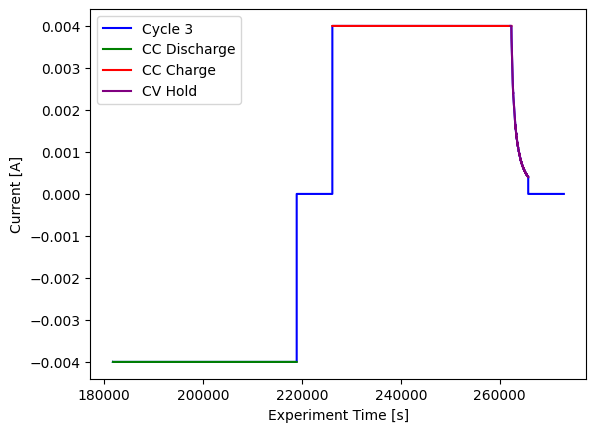

In [9]:
CC_discharge = discharge.constant_current(0)
CC_charge = charge.constant_current(0)
CV_hold = cycle_3.constant_voltage(0)

fig, ax = plt.subplots()
cycle_3.plot(
    x="Experiment Time [s]", y="Current [A]", ax=ax, color="blue", label="Cycle 3"
)
CC_discharge.plot(
    x="Experiment Time [s]", y="Current [A]", ax=ax, color="green", label="CC Discharge"
)
CC_charge.plot(
    x="Experiment Time [s]", y="Current [A]", ax=ax, color="red", label="CC Charge"
)
CV_hold.plot(
    x="Experiment Time [s]", y="Current [A]", ax=ax, color="purple", label="CV Hold"
)
ax.set_ylabel("Current [A]")